In [4]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import sys
import warnings
sys.path.append('../')
from spectral_extraction.spectra_2d import spectra_2d
from spectral_extraction.ploting import plot2d_spectra
from spectral_extraction.fitting import make_fit,paralel_fit
from spectral_extraction.spectra_extraction_results import spectral_extraction_results_handler
from spectral_extraction.utils import guess_picks_image,find_signal
import pickle

In [6]:
spectral_extraction.__version__ 

'0.0.1'

In [7]:
%load_ext autoreload
%autoreload 2

In [38]:
# import astropy
# astropy.__version__

In [39]:
# from astropy.io import fits 
# plt.imshow(data/np.nanmax(data,axis=0),aspect="auto",vmin=0,vmax=1)

In [ ]:
image_path ="J1036-8544_MAPPED_SCI_MOS.fits"
Image2d=spectra_2d(image_path,center_cut = None ,size_cut=50,verbose=True)

#### Check the cutout for any case

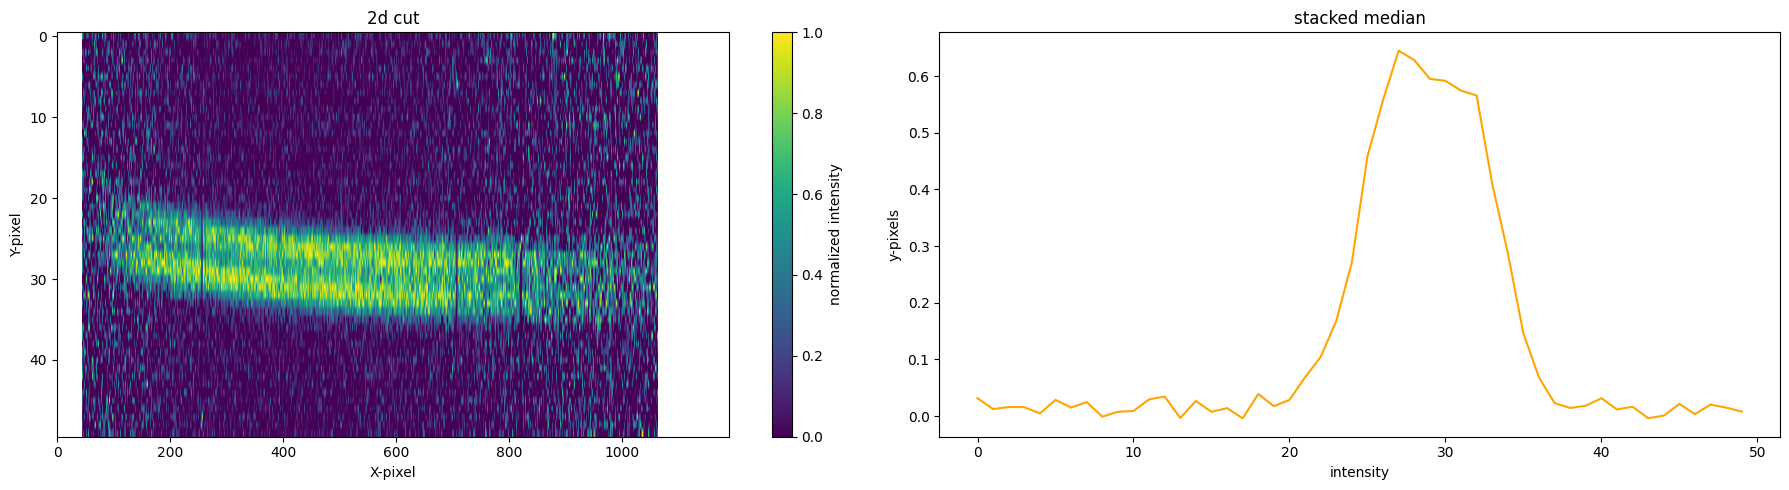

In [40]:
Image2d.plot_cut_out()

## The modeling 

In [43]:
image=Image2d.data2d
picks=np.array([guess_picks_image(i,2) for i in image.T])
guess_center = np.nanmedian(picks)
guess_separation = np.nanmean(picks[:,1:]) - np.nanmedian(picks) 
print(f"The guess center is {guess_center}, and the guess separation is {guess_separation}") # keep the sign in the separation to be consistent with the code

The guess center is 29.0, and the guess separation is -3.3418217433888344


In [44]:
full_result_step_1 = paralel_fit(image,2,initial_center=guess_center,initial_separation=[guess_separation],pixel_limit=[],bound_sigma=[2],distribution="gaussian",mask_list=[],\
                          param_value=None,param_limit=None,param_fix=None)# at the moment the mask only work in the 

The code will be executed in 16 core using 2 sources an a gaussian distribution


DONE:   0%|          | 0/1191 [00:00<?, ?it/s]

mean value for value_center_1 if 30.38522824882398


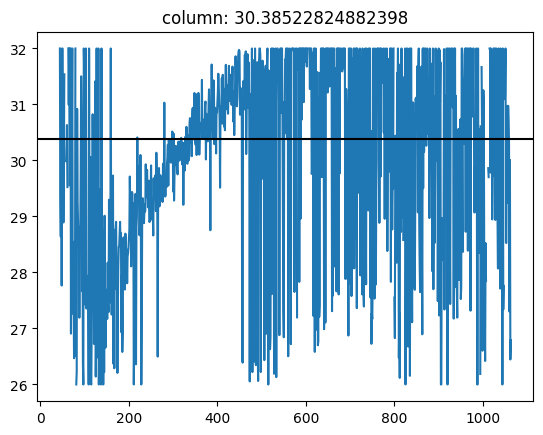

mean value for value_center_2 if 26.08852221332979


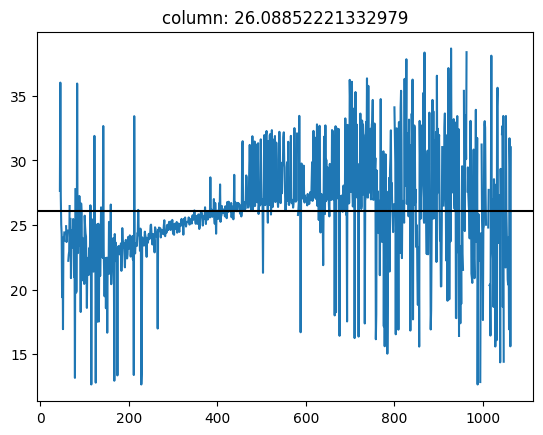

mean value for value_separation_2 if -4.947327842196484


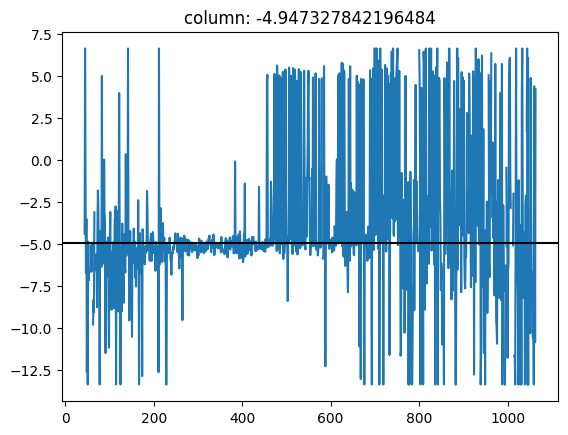

mean value for value_sigma_2 if 1.8400202844112643


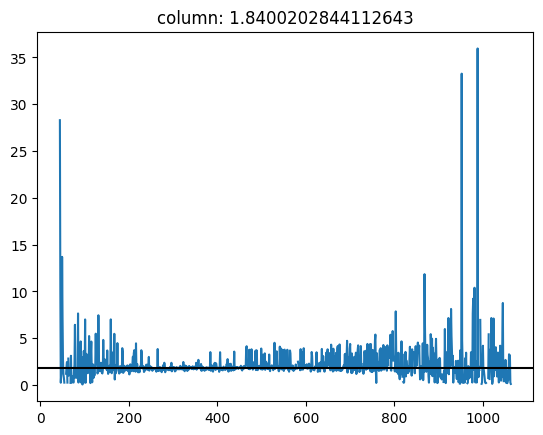

In [45]:
serh_1=spectral_extraction_results_handler(full_result_step_1)
median_c1=serh_1.plot_column("value_center_1")
median_c2=serh_1.plot_column("value_center_2")
median_s2=serh_1.plot_column("value_separation_2")
median_sigma2=serh_1.plot_column("value_sigma_2")

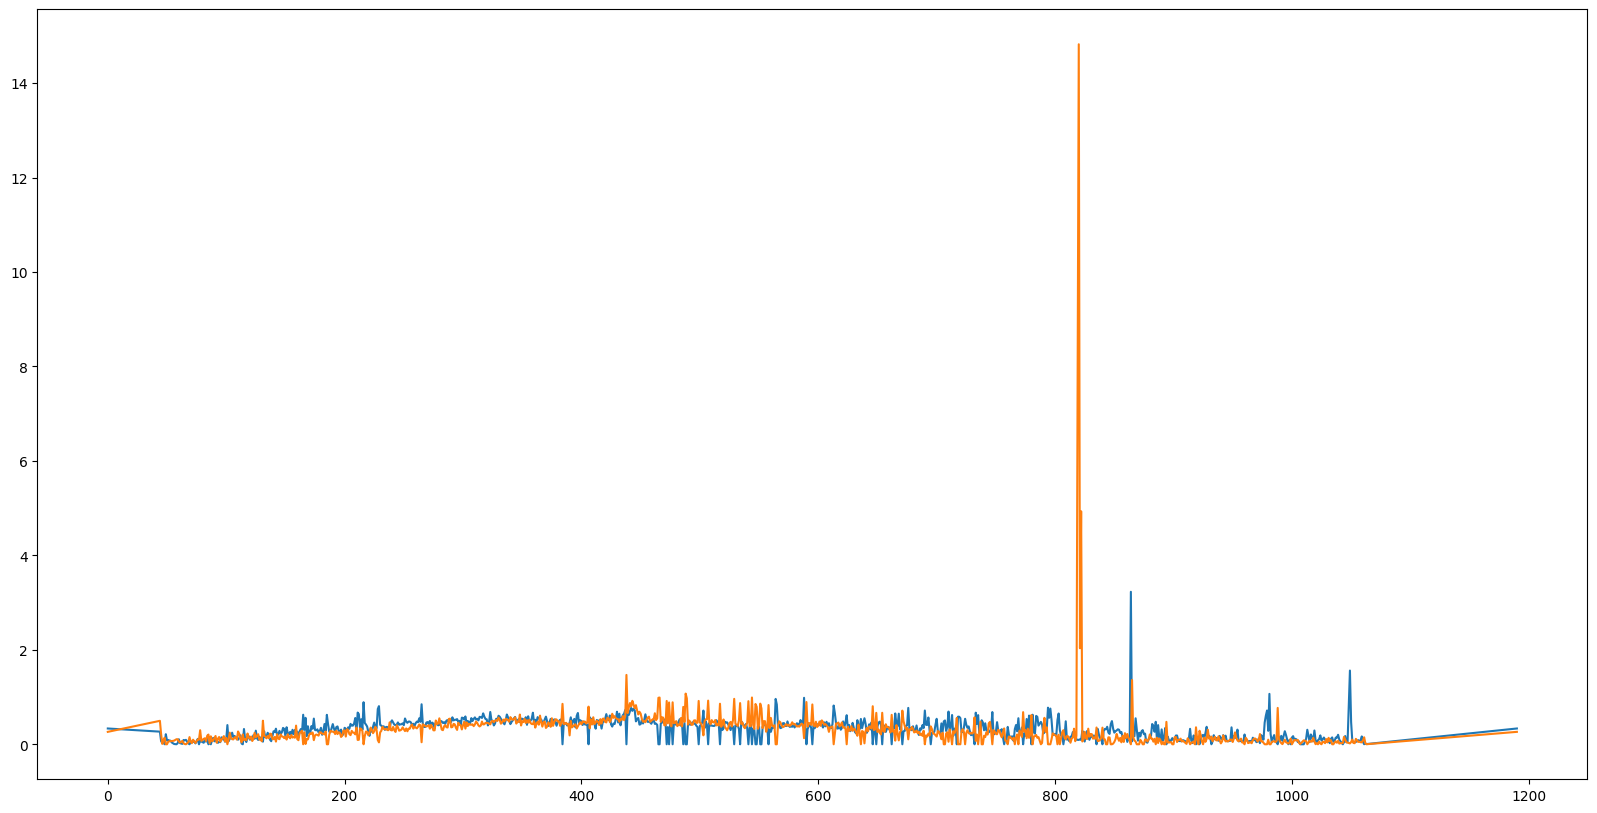

In [46]:
flux_1 = serh_1.spectras1d['flux_1']
flux_2 = serh_1.spectras1d['flux_2']
plt.figure(figsize=(20,10))
plt.plot(flux_1)
plt.plot(flux_2)

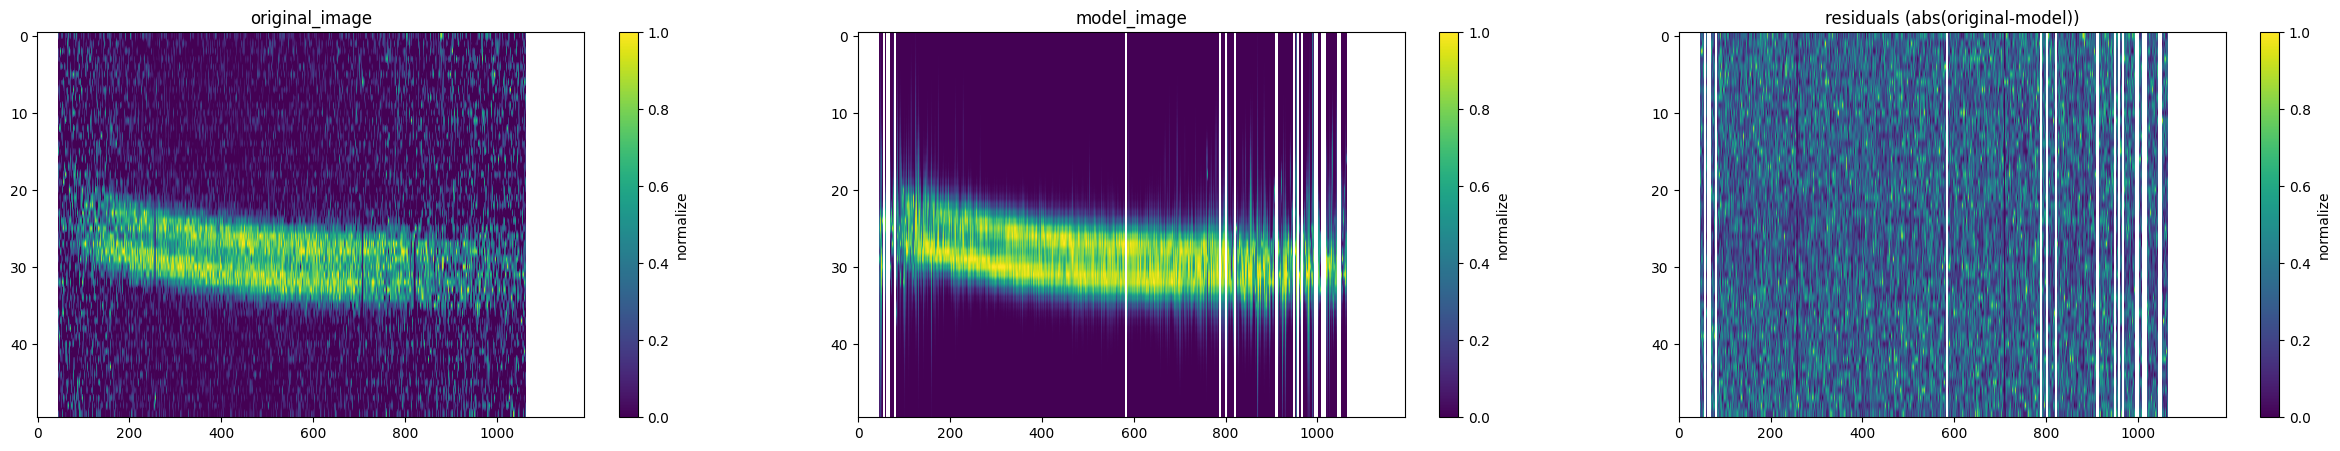

In [47]:
serh_1.plot_2d_image_residuals()

#### Now, as you can see, the spectra don't look good, so a second step is required; in this second step, we can use the median values of the previous step and add some constraints to avoid non logical results, has example change the order of the central position

In [48]:
full_result_2 = paralel_fit(image,2,initial_center=median_c1,initial_separation=[median_s2],pixel_limit=[],bound_sigma=[2],distribution="gaussian",mask_list=[],\
                          param_value={"sigma_1":median_sigma2},param_limit={"separation_2":[-10,-0.01],"sigma_1":[median_sigma2*0.85,median_sigma2*1.15]})# 
#results from this are  {"image":image_copy.T,"full_fit":full_fit,"normalize_matrix":normalize_matrix,"num_source":num_source,"distribution":kwargs["distribution"],"mask":mask,"original_image":image}

The code will be executed in 16 core using 2 sources an a gaussian distribution


DONE:   0%|          | 0/1191 [00:00<?, ?it/s]

### save your results could be a good idea to do that 

In [49]:

with open('my_model_extraction.pickle', 'wb') as handle:
    pickle.dump(full_result_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('my_model_extraction.pickle', 'rb') as handle:
    saved_model = pickle.load(handle)


In [50]:
serh_2=spectral_extraction_results_handler(full_result_2,conditions={"min":{"rsquared":0.0},"max":{"flux_1":np.percentile(flux_1,99.0),"flux_2":np.percentile(flux_2,99.0)}},header=Image2d.header) 

mean value for value_center_1 if 31.43134523052864


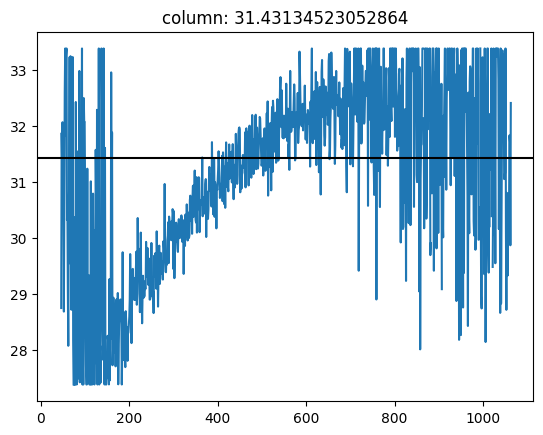

mean value for value_center_2 if 26.212614738512112


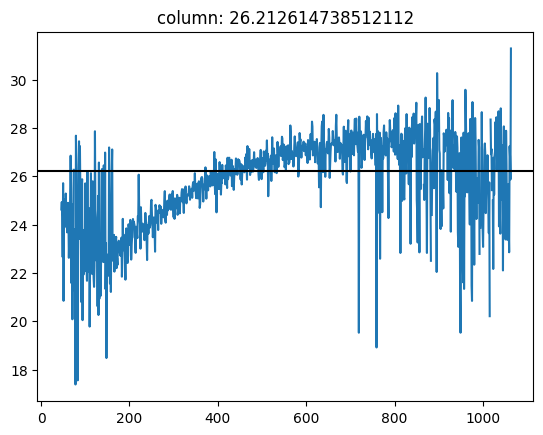

mean value for value_separation_2 if -5.17074490300551


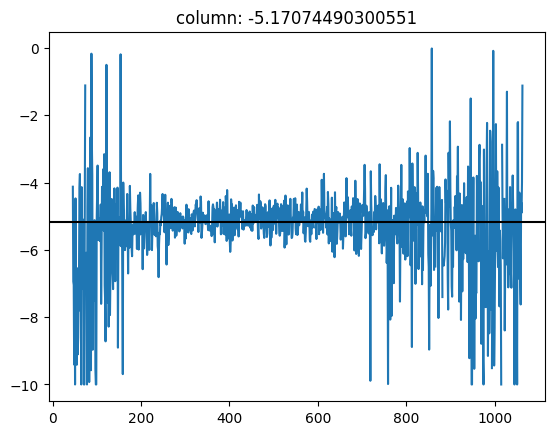

mean value for value_sigma_2 if 1.755602343768854


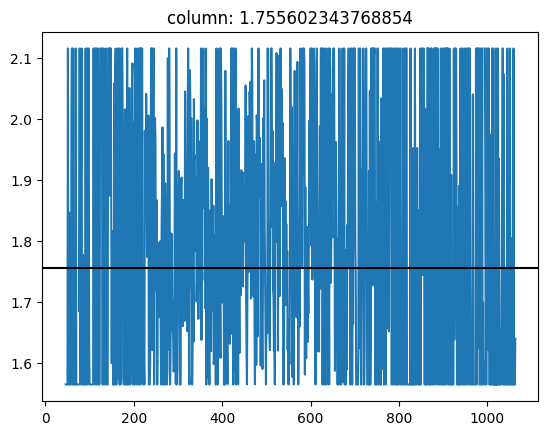

In [51]:
median_c1=serh_2.plot_column("value_center_1")
median_c2=serh_2.plot_column("value_center_2")
median_s2=serh_2.plot_column("value_separation_2")
median_sigma2=serh_2.plot_column("value_sigma_2")

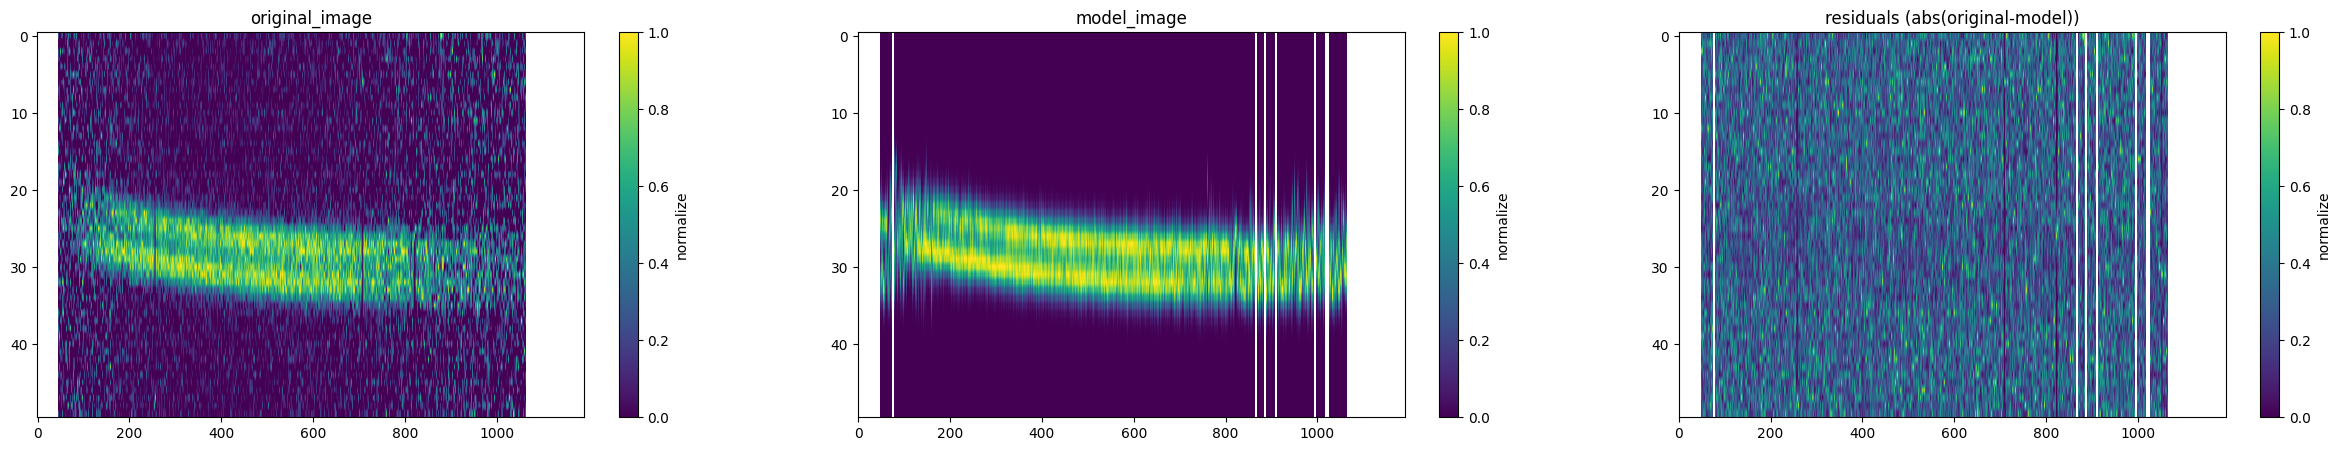

In [52]:
serh_2.plot_2d_image_residuals()

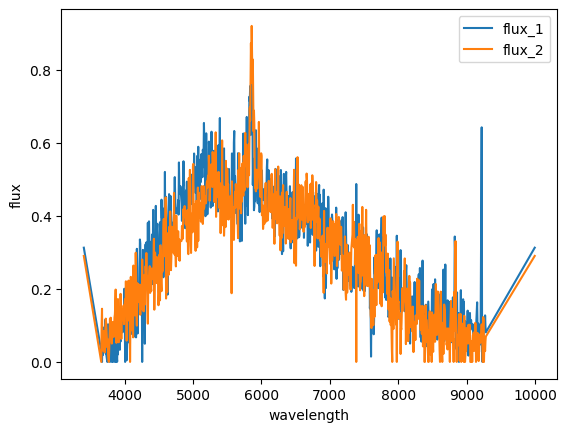

In [53]:
serh_2.plot_spectra()

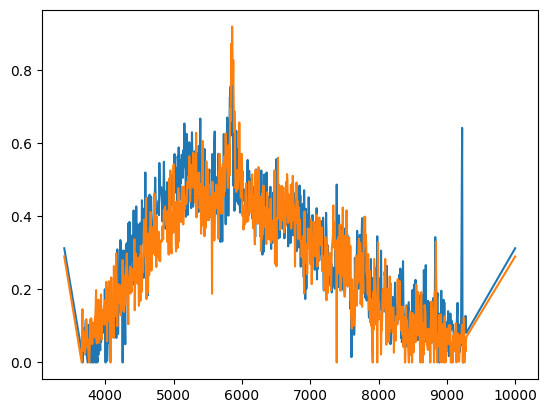

In [54]:
plt.plot(serh_2.cleaned_panda["wavelength"],serh_2.cleaned_panda["flux_1"])
plt.plot(serh_2.cleaned_panda["wavelength"],serh_2.cleaned_panda["flux_2"])

#### How to save "spectral_extraction_results_handler" in a efficent way is not done yet but sooner